# 한글 음절 구조 분석

In [1]:
from unicodedata import name, normalize
import pandas as pd
from collections import Counter
import seaborn as sns

In [2]:
text = '선명하게 핥고 있었다'
for char in text:
    print(char, name(char))

선 HANGUL SYLLABLE SEON
명 HANGUL SYLLABLE MYEONG
하 HANGUL SYLLABLE HA
게 HANGUL SYLLABLE GE
  SPACE
핥 HANGUL SYLLABLE HALT
고 HANGUL SYLLABLE GO
  SPACE
있 HANGUL SYLLABLE ISS
었 HANGUL SYLLABLE EOSS
다 HANGUL SYLLABLE DA


In [3]:
for char in text:
    for graph in normalize('NFKD', char):
        print(graph, name(graph))

ᄉ HANGUL CHOSEONG SIOS
ᅥ HANGUL JUNGSEONG EO
ᆫ HANGUL JONGSEONG NIEUN
ᄆ HANGUL CHOSEONG MIEUM
ᅧ HANGUL JUNGSEONG YEO
ᆼ HANGUL JONGSEONG IEUNG
ᄒ HANGUL CHOSEONG HIEUH
ᅡ HANGUL JUNGSEONG A
ᄀ HANGUL CHOSEONG KIYEOK
ᅦ HANGUL JUNGSEONG E
  SPACE
ᄒ HANGUL CHOSEONG HIEUH
ᅡ HANGUL JUNGSEONG A
ᆴ HANGUL JONGSEONG RIEUL-THIEUTH
ᄀ HANGUL CHOSEONG KIYEOK
ᅩ HANGUL JUNGSEONG O
  SPACE
ᄋ HANGUL CHOSEONG IEUNG
ᅵ HANGUL JUNGSEONG I
ᆻ HANGUL JONGSEONG SSANGSIOS
ᄋ HANGUL CHOSEONG IEUNG
ᅥ HANGUL JUNGSEONG EO
ᆻ HANGUL JONGSEONG SSANGSIOS
ᄃ HANGUL CHOSEONG TIKEUT
ᅡ HANGUL JUNGSEONG A


In [4]:
def is_hangul(char):
    if char:
        charname = name(char)
        return charname.startswith('HANGUL')
    else:
        return False

def is_hangul_syllable(char):
    return '가' <= char <= '힣'

def get_hangul_name(char:str):
    if is_hangul(char):
        charname = name(char)
        return charname.split()[-1]
    else:
        return ''

def decompose_hangul(char):
    return normalize('NFKD', char)

for char in text:
    print(char, get_hangul_name(char))
    graphs = decompose_hangul(char)
    for graph in graphs:
        print(graph, get_hangul_name(graph))

선 SEON
ᄉ SIOS
ᅥ EO
ᆫ NIEUN
명 MYEONG
ᄆ MIEUM
ᅧ YEO
ᆼ IEUNG
하 HA
ᄒ HIEUH
ᅡ A
게 GE
ᄀ KIYEOK
ᅦ E
  
  
핥 HALT
ᄒ HIEUH
ᅡ A
ᆴ RIEUL-THIEUTH
고 GO
ᄀ KIYEOK
ᅩ O
  
  
있 ISS
ᄋ IEUNG
ᅵ I
ᆻ SSANGSIOS
었 EOSS
ᄋ IEUNG
ᅥ EO
ᆻ SSANGSIOS
다 DA
ᄃ TIKEUT
ᅡ A


In [5]:
def get_onset_type(onset:str):
    charname = get_hangul_name(onset)
    if charname != 'IEUNG':
        return 'C' 
    else:
        return ''

glides = ('W', 'Y')
vowels = ('A', 'E', 'I', 'O', 'U')

def get_nucleus_type(nucleus:str):
    charname = get_hangul_name(nucleus)
    if charname.startswith(glides):
        return 'GV'
    elif charname.endswith(glides):
        return 'VG'
    else:
        return 'V'

def get_coda_type(coda:str):
    charname = get_hangul_name(coda)
    if charname:
        n = len(charname.split('-'))
    else:
        n = 0
    
    return 'C' * n

def get_syllable_type(syllable:str):
    if is_hangul_syllable(syllable):
        graphs = decompose_hangul(syllable)
        onset, nucleus = graphs[0:2]
        coda = graphs[2:]
        return get_onset_type(onset) + get_nucleus_type(nucleus) + get_coda_type(coda)
    else:
        return ''

for char in text:
    print(char, get_syllable_type(char))

선 CVC
명 CGVC
하 CV
게 CV
  
핥 CVCC
고 CV
  
있 VC
었 VC
다 CV


## 12. 단어의 음절 유형 추출

In [6]:
def get_word_syllable_types(word):
    """단어의 각 음절 유형을 튜플로 반환"""
    types = []
    for char in word:
        syl_type = get_syllable_type(char)
        if syl_type:
            types.append(syl_type)
    return tuple(types)

# 테스트
words = text.split()
for word in words:
    print(word, get_word_syllable_types(word))

선명하게 ('CVC', 'CGVC', 'CV', 'CV')
핥고 ('CVCC', 'CV')
있었다 ('VC', 'VC', 'CV')


## 13. 데이터프레임에 음절 유형 추가

명사 단어들의 음절 구조를 분석합니다.

In [42]:
# CSV에서 데이터 읽기
csvfilename = '../data/nikl/stdict_20251005_basic_info.csv'
df = pd.read_csv(csvfilename, index_col='target_code')

# 명사만 필터링
nouns = df[df['pos'] == '명사'].copy()
print(f"명사 개수: {len(nouns):,}개")

# 음절 유형 칼럼 추가
print("\n음절 유형 계산 중...")
nouns['syllable_type'] = nouns['word'].apply(get_word_syllable_types)

# 확인
print("\n음절 유형이 추가된 데이터프레임:")
print(nouns[['word', 'word_type', 'syllable_type']].head(10))

명사 개수: 269,580개

음절 유형 계산 중...

음절 유형이 추가된 데이터프레임:
             word word_type   syllable_type
target_code                                
1            가경-지       한자어  (CV, CGVC, CV)
3            가계02       한자어       (CV, CGV)
6            가계04       한자어       (CV, CGV)
7            가계05       한자어       (CV, CGV)
8            가계07       한자어       (CV, CGV)
9            가계08       한자어       (CV, CGV)
10           가계09       한자어       (CV, CGV)
11           가계10       한자어       (CV, CGV)
13           가계-도       한자어   (CV, CGV, CV)
14           가계-례       한자어  (CV, CGV, CGV)


## 14. 음절 유형 빈도 계산

In [49]:
# 모든 음절 유형 수집
nouns['syllable_index'] = nouns['syllable_type'].apply(lambda x: list(enumerate(x, start=1)))
nouns

,word,word_unit,word_type,pos,syllable_type,syllable_index
target_code,,,,,,
1,가경-지,단어,한자어,명사,"(CV, CGVC, CV)","[(1, CV), (2, CGVC), (3, CV)]"
3,가계02,단어,한자어,명사,"(CV, CGV)","[(1, CV), (2, CGV)]"
6,가계04,단어,한자어,명사,"(CV, CGV)","[(1, CV), (2, CGV)]"
7,가계05,단어,한자어,명사,"(CV, CGV)","[(1, CV), (2, CGV)]"
8,가계07,단어,한자어,명사,"(CV, CGV)","[(1, CV), (2, CGV)]"
...,...,...,...,...,...,...
535770,턱-끝,단어,고유어,명사,"(CVC, CVC)","[(1, CVC), (2, CVC)]"
535771,만자-무늬,단어,혼종어,명사,"(CVC, CV, CV, CGV)","[(1, CVC), (2, CV), (3, CV), (4, CGV)]"
536189,울음-통01,단어,고유어,명사,"(VC, VC, CVC)","[(1, VC), (2, VC), (3, CVC)]"


In [53]:
noun_syllables = nouns.explode(['syllable_index']).dropna()
noun_syllables[['syllable_index', 'syllable_type']] = pd.DataFrame(
    noun_syllables['syllable_index'].tolist(), 
    index=noun_syllables.index
)

# # 2단계: 인덱스 결합
noun_syllables.index = noun_syllables.index.astype(str) + '.' + noun_syllables['syllable_index'].astype(int).astype(str)
noun_syllables

,word,word_unit,word_type,pos,syllable_type,syllable_index
1.1,가경-지,단어,한자어,명사,CV,1
1.2,가경-지,단어,한자어,명사,CGVC,2
1.3,가경-지,단어,한자어,명사,CV,3
3.1,가계02,단어,한자어,명사,CV,1
3.2,가계02,단어,한자어,명사,CGV,2
...,...,...,...,...,...,...
536190.1,재-벌01,단어,혼종어,명사,CV,1
536190.2,재-벌01,단어,혼종어,명사,CVC,2
536191.1,한-문학02,단어,한자어,명사,CVC,1
536191.2,한-문학02,단어,한자어,명사,CVC,2


In [54]:
noun_syllables.value_counts('syllable_type')

syllable_type
CVC     309434
CV      283258
CGVC     43773
VC       33872
V        33349
CGV      29320
GVC      26247
GV       17367
CVCC      1042
VCC        128
GVCC         4
Name: count, dtype: int64

<Axes: xlabel='syllable_type', ylabel='count'>

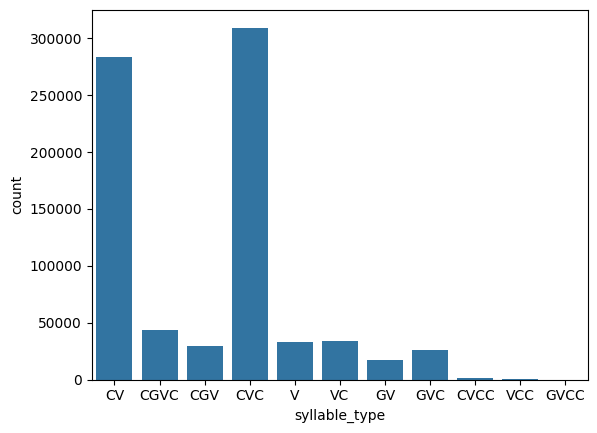

In [55]:
sns.countplot(noun_syllables, x='syllable_type')

## 15. 단어 유형별 음절 구조 비교

In [56]:
def count_syllable_types_by_word_type(df):
    """단어 유형별 음절 유형 빈도를 계산하여 데이터프레임으로 반환"""
    result = {}
    
    for word_type in ['고유어', '한자어', '외래어', '혼종어']:
        # 해당 단어 유형 필터링
        subset = df[df['word_type'] == word_type]
        
        # 음절 유형 수집
        types = []
        for t in subset['syllable_type']:
            types.extend(t)
        
        # 빈도 계산
        result[word_type] = Counter(types)
    
    return pd.DataFrame(result).fillna(0).T

# 테이블 생성
table = count_syllable_types_by_word_type(nouns)

# 칼럼 정렬 (알파벳 순)
table = table[sorted(table.columns)]

print("단어 유형별 음절 유형 빈도:")
print(table.astype(int))

단어 유형별 음절 유형 빈도:
       CGV   CGVC      CV     CVC  CVCC     GV    GVC  GVCC      V     VC  VCC
고유어   2354   2247   48713   48516   733    933    930     4   7192   5033   99
한자어  22521  37453  151241  205334     0  14355  22631     0  12104  22358    0
외래어   1267    614   46132   13934     1    878    292     0   8535   2721    0
혼종어   3178   3459   37172   41650   308   1201   2394     0   5518   3760   29


In [57]:
# 백분율로 표현
table_pct = table.apply(lambda x: x / x.sum() * 100, axis=1)

print("\n단어 유형별 음절 유형 비율 (%):")
print(table_pct.round(2))


단어 유형별 음절 유형 비율 (%):
      CGV  CGVC     CV    CVC  CVCC    GV   GVC  GVCC      V    VC   VCC
고유어  2.02  1.92  41.72  41.55  0.63  0.80  0.80   0.0   6.16  4.31  0.08
한자어  4.61  7.67  30.99  42.08  0.00  2.94  4.64   0.0   2.48  4.58  0.00
외래어  1.70  0.83  62.03  18.74  0.00  1.18  0.39   0.0  11.48  3.66  0.00
혼종어  3.22  3.51  37.67  42.21  0.31  1.22  2.43   0.0   5.59  3.81  0.03


/home/codespace/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/codespace/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/codespace/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/codespace/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/codespace/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/codespace/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50808 (\N{HANGUL SYLLA

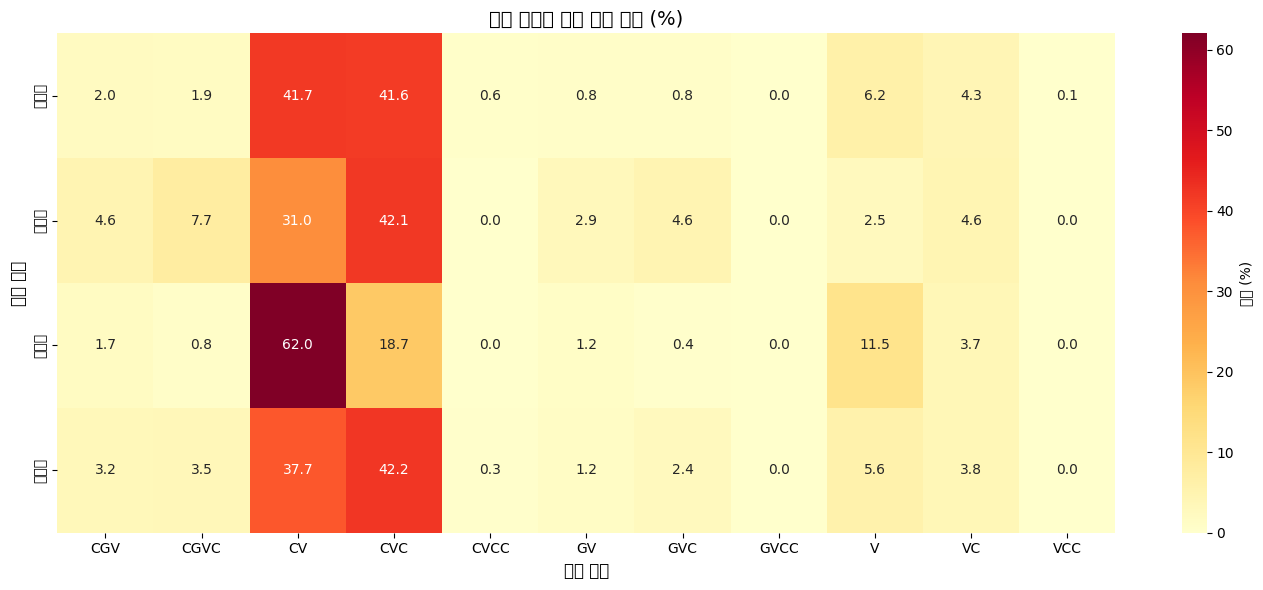

In [58]:
# 히트맵으로 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.heatmap(table_pct, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': '비율 (%)'})
plt.xlabel('음절 유형', fontsize=12)
plt.ylabel('단어 유형', fontsize=12)
plt.title('단어 유형별 음절 유형 분포 (%)', fontsize=14)
plt.tight_layout()
plt.show()

## 16. 분석 결과 해석

단어 유형별 음절 구조의 특징:

1. **한자어**: CVC, CV 구조 선호 (중국어 음절 구조 반영)
2. **고유어**: 다양한 음절 구조 (VCC, CVCC 포함)
3. **외래어**: CV 구조 높은 비율 (영어, 일본어 음절 단순화)
4. **혼종어**: 고유어와 한자어의 중간적 특성

## 17. 추가 분석 예제

특정 음절 유형을 가진 단어 찾기

In [60]:
# CVCC 종성을 가진 고유어 명사 찾기
cvcc_nouns = nouns[
    (nouns['word_type'] == '고유어') & 
    (nouns['syllable_type'].apply(lambda x: 'CVCC' in x))
]

print("CVCC 음절을 포함한 고유어 명사 (20개):")
print(cvcc_nouns['word'].head(20).tolist())

CVCC 음절을 포함한 고유어 명사 (20개):
['가늠-값', '가로-넓이', '갈이-흙', '갉아먹-기', '갉-이', '갉이-질', '감-흙', '갓-밝이', '값-어치', '갯-값', '거름-흙', '겉-흙', '겉-넓이', '건-흙', '검은넓적-하늘소', '검은-흙', '게잡이짧은꼬리-원숭이', '고기-닭', '곪-기', '곬']


In [62]:
# 모든 음절이 CV 구조인 외래어 찾기
all_cv_words = nouns[
    (nouns['word_type'] == '외래어') & 
    (nouns['syllable_type'].apply(lambda x: all(t == 'CV' for t in x)))
]

print("\n모든 음절이 CV 구조인 외래어 (20개):")
print(all_cv_words['word'].head(20).tolist())


모든 음절이 CV 구조인 외래어 (20개):
['가나01', '가나02', '가니메데', '가고시마', '가나03', '가다03', '가다메스', '가보로네', '가보르', '가드너01', '가드너02', '가드너03', '가르보르그', '가보05', '가보06', '가부토초', '가스파초', '가스', '가자11', '가스-버너']


## 정리

오늘 실습에서 배운 내용:

1. **lxml.etree를 사용한 XML 파싱**
   - `fromstring()`: 문자열을 XML로 파싱
   - `find()`, `findall()`: 요소 탐색
   - 조건부 요소 접근 (None 체크)

2. **대규모 데이터 처리**
   - ZIP 파일에서 직접 읽기
   - 반복문으로 여러 파일 처리
   - pandas 데이터프레임으로 구조화

3. **한글 음절 분석**
   - 유니코드 한글 음절 분해
   - 음절 유형 판별 알고리즘
   - 언어학적 통계 분석